Using device: cuda
Data loading complete. Found 40 unique persons processed.
Training images: 240, Testing images: 80

 Starting training...


Epoch 50/50: 100%|██████████| 75/75 [00:09<00:00,  7.59it/s, loss=0.0924]



 Training Finished. Model saved to 'D:\\Mini Project\siamese_shufflenet_model.pth'

 Evaluating model performance...
 AUC (Area Under Curve): 0.9575
 EER (Equal Error Rate): 6.25% at threshold 0.61
 Results saved to 'D:\\Mini Project\training_results_shufflenet.json'
 Displaying ROC curve plot...


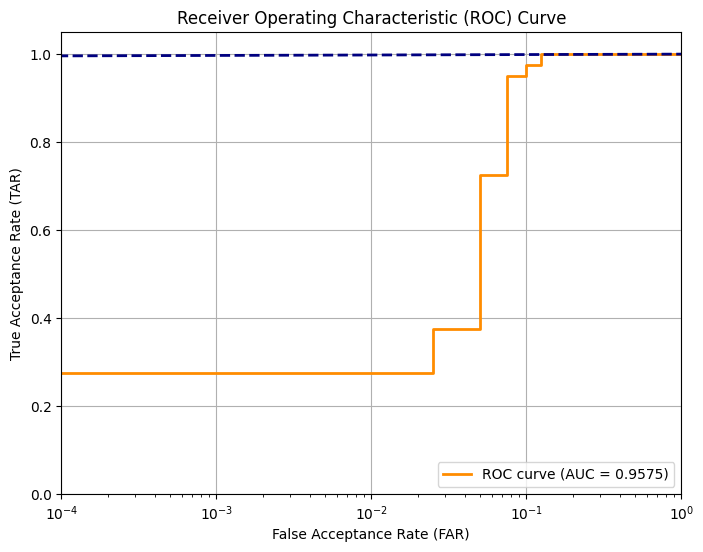

In [2]:
# train_model.py

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import numpy as np
import json
from itertools import combinations
from collections import defaultdict
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore")

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
class Config:
    DATASET_PATH = "D:\\Mini Project\\Fvc2002\\fingerprints"
    SAVE_DIR = r"D:\\Mini Project"
    IMAGE_SIZE = (224, 224) 
    BATCH_SIZE = 16
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    TRAIN_SPLIT_COUNT = 6
    # Updated filenames for the new model
    MODEL_SAVE_PATH = os.path.join(SAVE_DIR, "siamese_shufflenet_model.pth")
    RESULTS_FILE = os.path.join(SAVE_DIR, "training_results_shufflenet.json")

# ==============================================================================
# 2. ROBUST PRE-PROCESSING FUNCTIONS
# ==============================================================================
def extract_roi(image):
    """A robust ROI extraction using a simple intensity threshold."""
    if image is None: return None
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return image
    try:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        if w > 10 and h > 10: return image[y:y+h, x:x+w]
        else: return image
    except Exception: return image

def center_and_pad(image, target_size=(224, 224)):
    """Centers an image in a new square canvas."""
    if image is None: return np.zeros(target_size, dtype=np.uint8)
    h, w = image.shape[:2]
    if h <= 0 or w <= 0: return np.zeros(target_size, dtype=np.uint8)
    canvas = np.zeros(target_size, dtype=np.uint8)
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    if new_w <= 0 or new_h <= 0: return np.zeros(target_size, dtype=np.uint8)
    try:
        resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    except cv2.error: return np.zeros(target_size, dtype=np.uint8)
    pad_y, pad_x = (target_size[0] - new_h) // 2, (target_size[1] - new_w) // 2
    canvas[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized_img
    return canvas

# ==============================================================================
# 3. DATA LOADING & PREPARATION
# ==============================================================================
def load_and_split_data(root_path, train_count):
    person_images = defaultdict(list)
    for subdir, _, files in os.walk(root_path):
        for file in sorted(files):
            if file.lower().endswith(('.tif', '.png', '.jpg')):
                folder_name = os.path.basename(subdir)
                person_num = file.split('_')[0]
                unique_person_id = f"{folder_name}_{person_num}"
                person_images[unique_person_id].append(os.path.join(subdir, file))
    if not person_images: return None, None
    train_files, test_files = [], []
    for person_id, images in person_images.items():
        if len(images) < 8:
            print(f"Warning: Skipping person {person_id}, only found {len(images)} images.")
            continue
        random.shuffle(images)
        train_files.extend([(img, person_id) for img in images[:train_count]])
        test_files.extend([(img, person_id) for img in images[train_count:]])
    print(f"Data loading complete. Found {len(person_images)} unique persons processed.")
    print(f"Training images: {len(train_files)}, Testing images: {len(test_files)}")
    return train_files, test_files

class FingerprintPairDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.transform = transform
        self.person_to_images = defaultdict(list)
        for img_path, person_id in file_list: self.person_to_images[person_id].append(img_path)
        self._create_pairs()
    def _create_pairs(self):
        self.pairs, self.pair_labels = [], []
        positive_pairs = [p for _, imgs in self.person_to_images.items() if len(imgs) > 1 for p in combinations(imgs, 2)]
        for p1, p2 in positive_pairs: self.pairs.append((p1, p2)); self.pair_labels.append(1)
        num_negative = len(positive_pairs)
        all_person_ids = list(self.person_to_images.keys())
        if len(all_person_ids) < 2: return
        while num_negative > 0:
            p_id1, p_id2 = random.sample(all_person_ids, 2)
            if not self.person_to_images[p_id1] or not self.person_to_images[p_id2]: continue
            img1, img2 = random.choice(self.person_to_images[p_id1]), random.choice(self.person_to_images[p_id2])
            if (img1, img2) not in self.pairs and (img2, img1) not in self.pairs:
                self.pairs.append((img1, img2)); self.pair_labels.append(0)
                num_negative -= 1
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        p1, p2 = self.pairs[i]
        img1_full, img2_full = cv2.imread(p1, 0), cv2.imread(p2, 0)
        img1_roi, img2_roi = extract_roi(img1_full), extract_roi(img2_full)
        img1_centered, img2_centered = center_and_pad(img1_roi, Config.IMAGE_SIZE), center_and_pad(img2_roi, Config.IMAGE_SIZE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img1, img2 = clahe.apply(img1_centered), clahe.apply(img2_centered)
        if self.transform: img1, img2 = self.transform(img1), self.transform(img2)
        return img1, img2, torch.tensor(self.pair_labels[i], dtype=torch.float32)

# ==============================================================================
# 4. MODEL AND EVALUATION
# ==============================================================================
class SiameseShuffleNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseShuffleNet, self).__init__()
        self.shufflenet = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        self.shufflenet.conv1[0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)
        num_ftrs = self.shufflenet.fc.in_features
        self.shufflenet.fc = nn.Linear(num_ftrs, embedding_dim)
        self.fc_head = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward_once(self, x): return self.shufflenet(x)
    def forward(self, input1, input2):
        output1, output2 = self.forward_once(input1), self.forward_once(input2)
        diff = torch.abs(output1 - output2)
        score = self.fc_head(diff).squeeze()
        if score.dim() == 0:
             score = score.unsqueeze(0)
        return score

def train_model(model, dataloader, device):
    print("\n Starting training...")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    model.train()
    for epoch in range(Config.EPOCHS):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")
        for i, (img1, img2, label) in enumerate(progress_bar):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            scores = model(img1, img2)
            loss = criterion(scores.clamp(min=1e-7, max=1-1e-7), label)
            loss.backward(); optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (i + 1)})
            
    os.makedirs(Config.SAVE_DIR, exist_ok=True)
    torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
    print(f"\n Training Finished. Model saved to '{Config.MODEL_SAVE_PATH}'")

def evaluate_and_show_results(model, dataloader, device):
    print("\n Evaluating model performance...")
    model.eval()
    all_labels, all_scores = [], []
    with torch.no_grad():
        for img1, img2, label in dataloader:
            scores = model(img1.to(device), img2.to(device))
            all_labels.extend(label.cpu().numpy()); all_scores.extend(scores.cpu().numpy())
    
    if len(np.unique(all_labels)) < 2:
        print("Error: Cannot generate report with only one class.")
        return
        
    fpr, tpr, thresholds_roc = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f" AUC (Area Under Curve): {roc_auc:.4f}")
    fnr = 1 - tpr; min_diff, eer_threshold, final_eer = float('inf'), 0.0, 0.0
    for i in range(len(fpr)):
        if abs(fpr[i] - fnr[i]) < min_diff:
            min_diff, eer_threshold, final_eer = abs(fpr[i] - fnr[i]), thresholds_roc[i], (fpr[i] + fnr[i]) / 2
    print(f" EER (Equal Error Rate): {final_eer * 100:.2f}% at threshold {eer_threshold:.2f}")

    results = {'eer_threshold': float(eer_threshold), 'auc': float(roc_auc)}
    with open(Config.RESULTS_FILE, 'w') as f: json.dump(results, f, indent=4)
    print(f" Results saved to '{Config.RESULTS_FILE}'")
    
    plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'); plt.xscale('log'); plt.xlim([1e-4, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Acceptance Rate (FAR)'); plt.ylabel('True Acceptance Rate (TAR)'); plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right"); plt.grid(True); print(" Displaying ROC curve plot..."); plt.show(); plt.close()

# ==============================================================================
# 5. MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    train_files, test_files = load_and_split_data(Config.DATASET_PATH, Config.TRAIN_SPLIT_COUNT)
    if train_files and test_files:
        train_transform = transforms.Compose([
            transforms.ToPILImage(), transforms.RandomRotation(degrees=5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])])
        test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])])
        train_dataset = FingerprintPairDataset(train_files, transform=train_transform)
        test_dataset = FingerprintPairDataset(test_files, transform=test_transform)
        train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
        model = SiameseShuffleNet().to(device)
        train_model(model, train_loader, device)
        evaluate_and_show_results(model, test_loader, device)
    else:
        print(f"Error: No images found or test/train split failed. Please check `DATASET_PATH` and data structure.")

--- Fingerprint Match Predictor (ShuffleNetV2) ---
Image 1: D:\\Mini Project\\Fvc2002\\fingerprints\\DB1_B\\102_2.tif
Image 2: D:\\Mini Project\\Fvc2002\\fingerprints\\DB4_B\\106_6.tif

Loaded model and optimal threshold: 0.6140


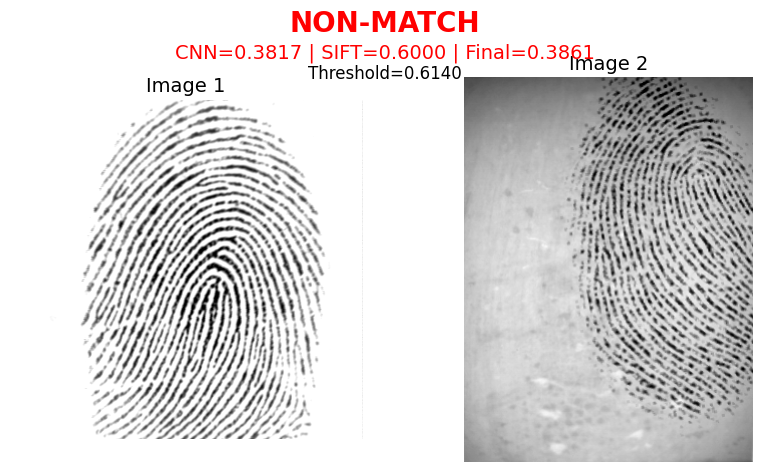

In [4]:
# predict_shufflenet.py

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
import json
import warnings

warnings.filterwarnings("ignore")

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
MODEL_SAVE_DIR = r"D:\\Mini Project"
MODEL_NAME = "siamese_shufflenet_model.pth"
RESULTS_NAME = "training_results_shufflenet.json"
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)
RESULTS_PATH = os.path.join(MODEL_SAVE_DIR, RESULTS_NAME)

IMAGE_SIZE = (224, 224)
WEIGHT_W = 0.02  # weight for SIFT contribution
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================================
# 2. MODEL DEFINITION (ShuffleNet Siamese)
# ==============================================================================
class SiameseShuffleNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseShuffleNet, self).__init__()
        # Load pretrained ShuffleNet
        self.shufflenet = models.shufflenet_v2_x1_0(
            weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT
        )

        # Modify first conv layer for grayscale input (1 channel)
        old_conv = self.shufflenet.conv1[0]
        self.shufflenet.conv1[0] = nn.Conv2d(
            1, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        # Replace the final FC layer with an embedding layer
        num_ftrs = self.shufflenet.fc.in_features
        self.shufflenet.fc = nn.Linear(num_ftrs, embedding_dim)

        # Comparison head
        self.fc_head = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        return self.shufflenet(x)

    def forward(self, input1, input2):
        out1 = self.forward_once(input1)
        out2 = self.forward_once(input2)
        diff = torch.abs(out1 - out2)
        score = self.fc_head(diff).squeeze()
        return score


# ==============================================================================
# 3. SIFT SIMILARITY FUNCTION
# ==============================================================================
def calculate_sift_score(img1_path, img2_path):
    """Compute SIFT feature matching ratio between two images."""
    img1, img2 = cv2.imread(img1_path, 0), cv2.imread(img2_path, 0)
    if img1 is None or img2 is None:
        return 0.0
    sift = cv2.SIFT_create()
    _, des1 = sift.detectAndCompute(img1, None)
    _, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        return 0.0
    matches = cv2.BFMatcher().knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return min(len(good) / 50.0, 1.0)


# ==============================================================================
# 4. PREDICTION + VISUALIZATION
# ==============================================================================
def predict_and_visualize(model, img1_path, img2_path, threshold):
    """Compute CNN+SIFT score and visualize match decision."""
    model.eval()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load and preprocess grayscale images
    img1_cv, img2_cv = cv2.imread(img1_path, 0), cv2.imread(img2_path, 0)
    if img1_cv is None or img2_cv is None:
        print("Error: Could not read one or both images.")
        return

    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img1_processed = clahe.apply(img1_cv)
    img2_processed = clahe.apply(img2_cv)

    # Transform to tensor
    t1 = transform(img1_processed).unsqueeze(0).to(DEVICE)
    t2 = transform(img2_processed).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        cnn_score = model(t1, t2).item()

    sift_score = calculate_sift_score(img1_path, img2_path)
    final_score = (1 - WEIGHT_W) * cnn_score + WEIGHT_W * sift_score

    decision = "MATCH" if final_score >= threshold else "NON-MATCH"
    color = "green" if decision == "MATCH" else "red"

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(Image.open(img1_path), cmap='gray')
    ax1.set_title("Image 1", fontsize=14)
    ax1.axis('off')

    ax2.imshow(Image.open(img2_path), cmap='gray')
    ax2.set_title("Image 2", fontsize=14)
    ax2.axis('off')

    result_text = f"CNN={cnn_score:.4f} | SIFT={sift_score:.4f} | Final={final_score:.4f}"
    threshold_text = f"Threshold={threshold:.4f}"

    plt.figtext(0.5, 0.96, decision, ha="center", va="bottom",
                fontsize=20, color=color, weight='bold')
    plt.figtext(0.5, 0.91, result_text, ha="center", va="bottom",
                fontsize=14, color=color)
    plt.figtext(0.5, 0.87, threshold_text, ha="center", va="bottom",
                fontsize=12, color='black')
    plt.show()


# ==============================================================================
# 5. MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    image_path_1 = r"D:\\Mini Project\\Fvc2002\\fingerprints\\DB1_B\\102_2.tif"
    image_path_2 = r"D:\\Mini Project\\Fvc2002\\fingerprints\\DB4_B\\106_6.tif"

    print("--- Fingerprint Match Predictor (ShuffleNetV2) ---")
    print(f"Image 1: {image_path_1}")
    print(f"Image 2: {image_path_2}")

    if not os.path.exists(MODEL_SAVE_PATH) or not os.path.exists(RESULTS_PATH):
        print("\nError: Model or results file not found. Please train the model first.")
    elif not os.path.exists(image_path_1) or not os.path.exists(image_path_2):
        print("\nError: One or both image paths are invalid.")
    else:
        with open(RESULTS_PATH, 'r') as f:
            results = json.load(f)
        optimal_threshold = results.get('eer_threshold', 0.5)

        # Load model and weights
        model = SiameseShuffleNet().to(DEVICE)
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        model.eval()

        print(f"\nLoaded model and optimal threshold: {optimal_threshold:.4f}")
        predict_and_visualize(model, image_path_1, image_path_2, optimal_threshold)


--- Fingerprint Match Predictor (ShuffleNetV2) ---
Image 1: D:\\Mini Project\\Fvc2002\\fingerprints\\DB1_B\\101_2.tif
Image 2: D:\\Mini Project\\Fvc2002\\fingerprints\\DB1_B\\101_6.tif

Loaded model and optimal threshold: 0.6140


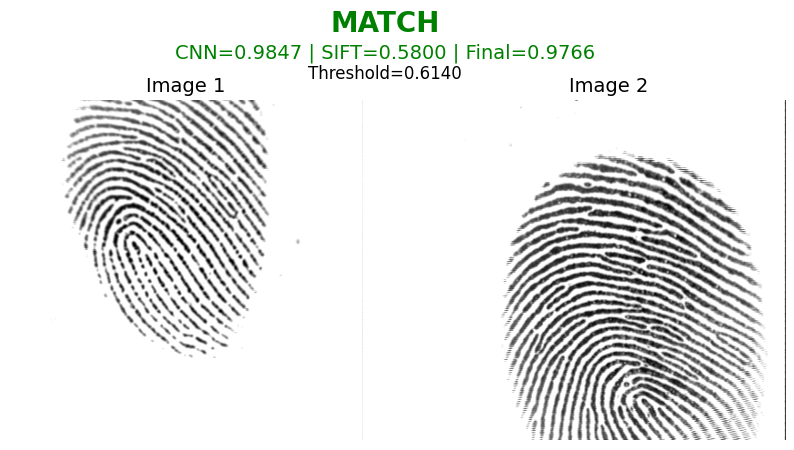

In [7]:
# predict_shufflenet.py

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
import json
import warnings

warnings.filterwarnings("ignore")

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
MODEL_SAVE_DIR = r"D:\\Mini Project"
MODEL_NAME = "siamese_shufflenet_model.pth"
RESULTS_NAME = "training_results_shufflenet.json"
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)
RESULTS_PATH = os.path.join(MODEL_SAVE_DIR, RESULTS_NAME)

IMAGE_SIZE = (224, 224)
WEIGHT_W = 0.02  # weight for SIFT contribution
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================================
# 2. MODEL DEFINITION (ShuffleNet Siamese)
# ==============================================================================
class SiameseShuffleNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseShuffleNet, self).__init__()
        # Load pretrained ShuffleNet
        self.shufflenet = models.shufflenet_v2_x1_0(
            weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT
        )

        # Modify first conv layer for grayscale input (1 channel)
        old_conv = self.shufflenet.conv1[0]
        self.shufflenet.conv1[0] = nn.Conv2d(
            1, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        # Replace the final FC layer with an embedding layer
        num_ftrs = self.shufflenet.fc.in_features
        self.shufflenet.fc = nn.Linear(num_ftrs, embedding_dim)

        # Comparison head
        self.fc_head = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        return self.shufflenet(x)

    def forward(self, input1, input2):
        out1 = self.forward_once(input1)
        out2 = self.forward_once(input2)
        diff = torch.abs(out1 - out2)
        score = self.fc_head(diff).squeeze()
        return score


# ==============================================================================
# 3. SIFT SIMILARITY FUNCTION
# ==============================================================================
def calculate_sift_score(img1_path, img2_path):
    """Compute SIFT feature matching ratio between two images."""
    img1, img2 = cv2.imread(img1_path, 0), cv2.imread(img2_path, 0)
    if img1 is None or img2 is None:
        return 0.0
    sift = cv2.SIFT_create()
    _, des1 = sift.detectAndCompute(img1, None)
    _, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        return 0.0
    matches = cv2.BFMatcher().knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return min(len(good) / 50.0, 1.0)


# ==============================================================================
# 4. PREDICTION + VISUALIZATION
# ==============================================================================
def predict_and_visualize(model, img1_path, img2_path, threshold):
    """Compute CNN+SIFT score and visualize match decision."""
    model.eval()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load and preprocess grayscale images
    img1_cv, img2_cv = cv2.imread(img1_path, 0), cv2.imread(img2_path, 0)
    if img1_cv is None or img2_cv is None:
        print("Error: Could not read one or both images.")
        return

    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img1_processed = clahe.apply(img1_cv)
    img2_processed = clahe.apply(img2_cv)

    # Transform to tensor
    t1 = transform(img1_processed).unsqueeze(0).to(DEVICE)
    t2 = transform(img2_processed).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        cnn_score = model(t1, t2).item()

    sift_score = calculate_sift_score(img1_path, img2_path)
    final_score = (1 - WEIGHT_W) * cnn_score + WEIGHT_W * sift_score

    decision = "MATCH" if final_score >= threshold else "NON-MATCH"
    color = "green" if decision == "MATCH" else "red"

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(Image.open(img1_path), cmap='gray')
    ax1.set_title("Image 1", fontsize=14)
    ax1.axis('off')

    ax2.imshow(Image.open(img2_path), cmap='gray')
    ax2.set_title("Image 2", fontsize=14)
    ax2.axis('off')

    result_text = f"CNN={cnn_score:.4f} | SIFT={sift_score:.4f} | Final={final_score:.4f}"
    threshold_text = f"Threshold={threshold:.4f}"

    plt.figtext(0.5, 0.96, decision, ha="center", va="bottom",
                fontsize=20, color=color, weight='bold')
    plt.figtext(0.5, 0.91, result_text, ha="center", va="bottom",
                fontsize=14, color=color)
    plt.figtext(0.5, 0.87, threshold_text, ha="center", va="bottom",
                fontsize=12, color='black')
    plt.show()


# ==============================================================================
# 5. MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    image_path_1 = r"D:\\Mini Project\\Fvc2002\\fingerprints\\DB1_B\\101_2.tif"
    image_path_2 = r"D:\\Mini Project\\Fvc2002\\fingerprints\\DB1_B\\101_6.tif"

    print("--- Fingerprint Match Predictor (ShuffleNetV2) ---")
    print(f"Image 1: {image_path_1}")
    print(f"Image 2: {image_path_2}")

    if not os.path.exists(MODEL_SAVE_PATH) or not os.path.exists(RESULTS_PATH):
        print("\nError: Model or results file not found. Please train the model first.")
    elif not os.path.exists(image_path_1) or not os.path.exists(image_path_2):
        print("\nError: One or both image paths are invalid.")
    else:
        with open(RESULTS_PATH, 'r') as f:
            results = json.load(f)
        optimal_threshold = results.get('eer_threshold', 0.5)

        # Load model and weights
        model = SiameseShuffleNet().to(DEVICE)
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        model.eval()

        print(f"\nLoaded model and optimal threshold: {optimal_threshold:.4f}")
        predict_and_visualize(model, image_path_1, image_path_2, optimal_threshold)
